> **Citing: Grayson, S., & Zhu, W. (Year). "Baby Cry Classifications Using Deep Learning." AIRCC Publishing Corporation, Volume 11 Number 14**


Also the notebook messages are generated by ChatGPT and verified by me to ensure proper idea is delivered to the reader

In [9]:
!pip install librosa==0.9.2

# <span style="font-family:cursive;text-align:center">⬇️ Import Libraries</span>

In [10]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
&nbsp;<b>The function create_spectrogram takes an input audio file path and generates a spectrogram image, saving it to the specified image file path. It utilizes the librosa library to load the audio, compute its mel spectrogram, and convert the power spectrogram to a decibel scale for better visualization.</b><br>
<br>
&nbsp;<b>The create_pngs_from_wavs function automates the process for multiple audio files within a given directory. It converts all .wav files in the specified input directory into spectrogram images, saving the resulting images to the designated output directory. This function makes use of the create_spectrogram function internally to generate the spectrogram images.

# <span style="font-family:cursive;text-align:center">📊 Data Processing and Training set generation</span>

In [11]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [1]:
create_pngs_from_wavs('data/donateacry_corpus/belly_pain', 'belly_pain')
create_pngs_from_wavs('data/donateacry_corpus/burping', 'burping')
create_pngs_from_wavs('data/donateacry_corpus/discomfort', 'discomfort')
create_pngs_from_wavs('data/donateacry_corpus/hungry', 'hungry')
create_pngs_from_wavs('data/donateacry_corpus/tired', 'tired')

NameError: name 'create_pngs_from_wavs' is not defined

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>Loading the images from the path</b><br>
</div>

In [ ]:
x = []
y = []

from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
     &nbsp;<b>The function takes in source patterns and their corresponding destination paths as input. If the destination directory doesn't exist, it creates the directory and proceeds with moving the files. It utilizes the glob module to identify the files based on the specified patterns and shutil for the file movement.
</b><br>
    <br>
    &nbsp;<b>With this we create the training dataset and leave a file for each type for testing</b><br>
</div>

In [ ]:
import glob
import shutil

def move_files(source_pattern, destination_path):
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        print(f"Directory '{destination_path}' created successfully.")
    else:
        print(f"Directory '{destination_path}' already exists.")

    files_to_move = glob.glob(source_pattern)
    for file_path in files_to_move[:-1]:
        shutil.move(file_path, destination_path)

# Define your directories and source patterns
directories = {
    'data/belly_pain_train/': 'data/belly_pain/*.png',
    'data/burping_train/': 'data/burping/*.png',
    'data/discomfort_train/': 'data/discomfort/*.png',
    'data/hungry_train/': 'data/hungry/*.png',
    'data/tired_train/': 'data/tired/*.png'
}

# Loop through the directories and move the files
for directory, source_pattern in directories.items():
    move_files(source_pattern, directory)

Directory 'belly_pain_train/' already exists.


Error: Destination path 'belly_pain_train/549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.png' already exists

In [ ]:
images, labels = load_images_from_path('data/belly_pain_train', 0)

x += images
y += labels

images, labels = load_images_from_path('data/burping_train', 1)

x += images
y += labels

images, labels = load_images_from_path('data/discomfort_train', 2)

x += images
y += labels

images, labels = load_images_from_path('data/hungry_train', 3)

x += images
y += labels

images, labels = load_images_from_path('data/tired_train', 4)

x += images
y += labels

In [ ]:
print(x)

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# <span style="font-family:cursive;text-align:center">⚙️ Model Training</span>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Model Architecture:</font></h3>
    
1. **Input Layer**: Accepts input images of shape (224, 224, 3), which corresponds to images with a height and width of 224 pixels and three color channels (RGB).
2. **Resizing Layer: Resizes the input images to a smaller size of (64, 64). This reduction in image dimensions may help speed up training.
3. **Normalization Layer**: Normalizes pixel values to have zero mean and unit variance, which aids in stabilizing and speeding up the training process.
4. **Convolutional Layers**: Utilizes two convolutional layers:
     - The first convolutional layer has 64 filters, a kernel size of 3x3, and ReLU activation.
     - The second convolutional layer has 128 filters, a kernel size of 3x3, and ReLU activation.
7. **MaxPooling Layer**: Performs max pooling with a pool size of 2x2, reducing the spatial dimensions of the feature maps.
8. **Dropout Layer**: Introduces a dropout rate of 20% to prevent overfitting by randomly deactivating a fraction of neurons during training.
9. **Flatten Layer**: Flattens the 2D feature maps into a 1D vector to prepare for the fully connected layers.
10. **RandomFourierFeatures Layer**: Incorporates random Fourier features with 5 components, which can approximate non-linear mappings efficiently for the data.
11. **Compilation**: Compiles the model using the AdamW optimizer with a learning rate of 0.01, categorical cross-entropy loss function (suitable for multi-class classification), and accuracy as the evaluation metric.

In [34]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout,Normalization,Resizing,InputLayer
#from tensorflow.keras.layers import RandomFourierFeatures
from tensorflow.keras.optimizers import Adam,Adafactor,AdamW,Lion
from tensorflow.keras.optimizers import Adadelta,Adagrad,Adamax,RMSprop,SGD,Nadam,Ftrl

model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))
model.add(Resizing(64,64))
model.add(Normalization())
model.add(Conv2D(64, 3, strides=1, activation='relu'))
model.add(Conv2D(128, 3, strides=1, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))
model.add(Flatten())
#model.add(RandomFourierFeatures(5))
#model.compile(optimizer=AdamW(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,655 (295.53 KB)

 Trainable params: 75,648 (295.50 KB)

 Non-trainable params: 7 (32.00 B)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=2,
                              min_lr=0.006,
                              verbose=1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Dropout(0.5),  # Dropout is only active during training
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), epochs=50,callbacks=[reduce_lr])

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7686 - loss: 28.8974 - val_accuracy: 0.8571 - val_loss: 7.6777 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6991 - loss: 5.8972 - val_accuracy: 0.8571 - val_loss: 2.6074 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8271 - loss: 1.2246 - val_accuracy: 0.8352 - val_loss: 0.9188 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8716 - loss: 0.4498 - val_accuracy: 0.8462 - val_loss: 0.7359 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8980 - loss: 0.3090 - val_accuracy: 0.8571 - val_loss: 0.7876 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9115 - loss: 0.2420 - val_accuracy: 0.8571 - val_loss: 0.8715 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9273 - loss: 0.1700 - val_accuracy:

In [21]:
import pickle

In [40]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

KeyboardInterrupt: 

In [44]:
loaded_model = pickle.load(open('test_model.sav', 'rb'))
# result = loaded_model.score(X_test, Y_test)


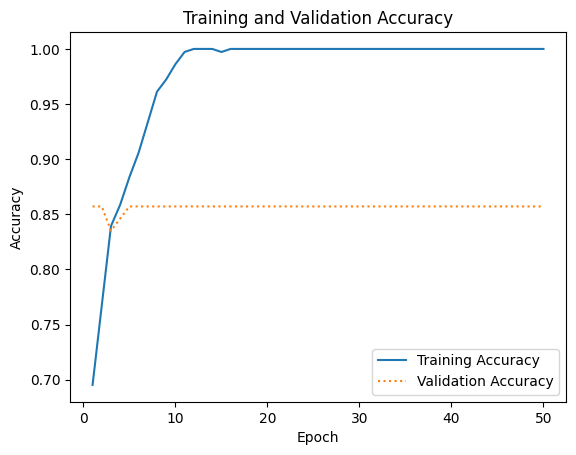

In [42]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()

# <span style="font-family:cursive;text-align:center">🧪 Testing</span>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    &nbsp;<b>For predicting on single tets files this code will be used. For each image file path obtained, the code performs the following operations:

- Loads the image using image.load_img() from the Keras preprocessing module, resizing it to the required dimensions of 224x224 pixels.
- Converts the image to a format compatible with the model for prediction (image.img_to_array() and np.expand_dims()).
- Utilizes the model for prediction on the image
- Retrieves class labels corresponding to the categories ('belly pain', 'burping', 'discomfort', 'hungry', 'tired').
- Prints the original file path and its predicted category, appending this information to the results list.</b>
</div>

In [ ]:
!pip install pyaudio

In [ ]:
!pip install Image

In [46]:
import pyaudio
import time
from PIL import Image
import io
import cv2

In [ ]:
!pip install keyboard

In [69]:
import wave

In [99]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 8
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [68]:
# import pyaudio
# import numpy as np
# import librosa
# import librosa.display
# import cv2
# import io
# import time
# import matplotlib.pyplot as plt
# from PIL import Image

class AudioHandler(object):
    def __init__(self, segment_duration=6.0):
        self.FORMAT = pyaudio.paFloat32
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024 * 2
        self.p = None
        self.stream = None
        self.audio_buffer = []  # buffer for accumulating audio chunks
        self.segment_duration = segment_duration  # seconds
        # Calculate required number of samples per segment
        self.required_samples = int(self.RATE * self.segment_duration)

    def start(self):
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format=self.FORMAT,
                                  channels=self.CHANNELS,
                                  rate=self.RATE,
                                  input=True,
                                  output=False,
                                  stream_callback=self.callback,
                                  frames_per_buffer=self.CHUNK)

    def stop(self):
        print("STOPPED")
        self.stream.close()
        self.p.terminate()

    def callback(self, in_data, frame_count, time_info, flag):
        # Append incoming audio chunk to buffer
        self.audio_buffer.append(in_data)

        # Convert current buffer to number of samples
        # Each chunk is a byte string representing float32 samples (4 bytes each)
        total_samples = (len(b"".join(self.audio_buffer)) // 4)
        if total_samples >= self.required_samples:
            # Concatenate all chunks into one bytes object
            combined_audio = b"".join(self.audio_buffer)
            numpy_array = np.frombuffer(combined_audio, dtype=np.float32)
            rms = np.sqrt(np.mean(numpy_array**2))
    
            # Define a threshold; you may need to adjust this value
            threshold = 0.001
            
            # Only process if the sound is loud enough
            if rms < threshold:
                return (in_data, pyaudio.paContinue)
            # Process the entire audio segment
            self.process_segment(numpy_array)
            
            # Clear the buffer after processing
            self.audio_buffer = []

        return (None, pyaudio.paContinue)

    def process_segment(self, numpy_array):
        print("processing")
        # Extract mel spectrogram features
        S = librosa.feature.melspectrogram(y=numpy_array, sr=self.RATE, n_mels=224)
        S_db = librosa.power_to_db(S, ref=np.max)
        print(type(S_db))
        S_db = cv2.resize(S_db, (224, 224))
        # img = librosa.display.specshow(S_db, x_axis='time',
        #                  y_axis='mel', sr=self.RATE,
        #                  fmax=8000)

        
        # # Plot the spectrogram (optional, for visualization)
        # plt.figure(figsize=(10, s4))
        # librosa.display.specshow(S_db, sr=self.RATE, x_axis='time', y_axis='mel')
        # plt.axis('off')
        # plt.draw()

        # Save plot to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()  # free memory
        buf.seek(0)

        # Open the image and process it for prediction
        img = Image.open(buf)
        img_resized = img.resize((224, 224))
        # S_resized = img_resized.resize((224,224))
        img_arr = np.array(img_resized)
        if img_arr.shape[-1] == 4:
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGBA2RGB)
        resized_arr = cv2.resize(img_arr, (224, 224))
        x = np.array(resized_arr)
        print(x)
        x = np.expand_dims(x, axis=0)
        # print(x)
        # Perform prediction (ensure your model is already loaded and accessible)
        y = loaded_model.predict(x)
        class_labels = ['belly pain', 'burping', 'discomfort', 'hungry', 'tired']
        print(f"Predicted: {class_labels[np.argmax(y)]}")

    def mainloop(self):
        try:
            while self.stream.is_active():
                time.sleep(2.0)
        except KeyboardInterrupt:
            pass

# Usage
audio = AudioHandler(segment_duration=6.0)  # or adjust segment_duration as needed
try:
    audio.start()
    audio.mainloop()
finally:
    audio.stop()    # Stop audio stream

STOPPED


In [ ]:
print("zzz")

In [ ]:
print("test")

In [ ]:
import glob
import os
create_pngs_from_wavs("data/test_belly_pain", "data/test_bp_pngs")

def get_png_files(directory):
    folders = ["data/test_bp_pngs"]
    # folders = ['belly_pain', 'burping', 'discomfort', 'tired'] 
    png_files = []

    for folder_name in folders:
        folder_path = os.path.join(directory, folder_name)
        if os.path.exists(folder_path):
            png_files.extend(glob.glob(os.path.join(folder_path, '*.png')))
        else:
            print(f"Folder '{folder_name}' does not exist in '{directory}'.")

    return png_files

directory_path = '' 
png_files_list = get_png_files(directory_path)

results = []
for file_path in png_files_list:
    x = image.load_img(file_path, target_size=(224, 224))

    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)/255
    # print(x)
    y = loaded_model.predict(x)

    class_labels = ['belly pain','burping','discomfort','hungry','tired']

    m = 0
    l = ''
    if(y[0][3]>0.9999):
        results.append(f"Original:{file_path.split('/')[0]} Predicted: {class_labels[3]}")
    elif (y[0][4]>0.0001):
        # for i, label in enumerate(class_labels):
        #     if(y[0][i]>0 and i != 3):
        #         m = y[0][i]
        #         l = label                                               
        # # print(f'{label}: {y[0][i]}')
        results.append(f"Original:{file_path.split('/')[0]} Predicted: {class_labels[4]}")
    else:
        results.append(f"Original:{file_path.split('/')[0]} Predicted: {class_labels[2]}")


    # for i, label in enumerate(class_labels):
    #     if(y[0][i]>0):
    #         m = y[0][i]
    #         l = label
    #     print(f'{label}: {y[0][i]}')
    # results.append(f"Original:{file_path.split('/')[0]} Predicted: {l}")

    # print(y[0][np.argmax(y)])
    
    # results.append(f"Original:{file_path.split('/')[0]} Predicted: {class_labels[np.argmax(y)]}")
    
print('\n')

for i in results:
    print(i)
    print('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Original:test_bp_pngs\549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.png Predicted: discomfort


Original:test_bp_pngs\5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757039803-1.7-m-48-bu.png Predicted: hungry


Original:test_bp_pngs\a40b9b8d-e4bc-457a-badf-f38bdbc0c358-1430017040912-1.7-m-26-dc.png Predicted: discomfort


Original:test_bp_pngs\angry-baby-cry-36152.png Predicted: hungry


Original:test_bp_pngs\baby-crying-1-225083.png Predicted: hungry


Original:test_bp_pngs\baby-crying-89895.png Predicted: discomfort


Original:test_bp_pngs\F24DE44B-762C-4149-AC92-96A5E57ED118-1430816949-1.0-m-04-bu copy.png Predicted: discomfort